In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
df=pd.read_csv("questions.csv")
df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0


In [2]:
df=df.dropna()
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

<Axes: xlabel='is_duplicate'>

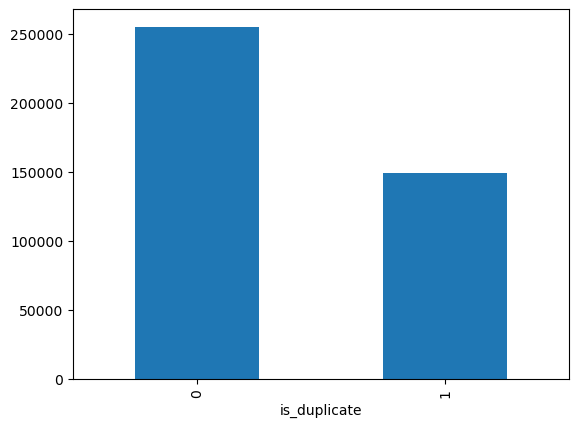

In [3]:
df["is_duplicate"].value_counts().plot(kind="bar")

In [4]:
df['question1']=df['question1'].str.lower()
df['question2']=df['question2'].str.lower()

import contractions 
df['question1']=df['question1'].apply(contractions.fix)
df['question2']=df['question2'].apply(contractions.fix)

df['question1'] = df['question1'].str.replace(r"[^a-zA-Z0-9?!\s]", " ", regex=True)
df['question2'] = df['question2'].str.replace(r"[^a-zA-Z0-9?!\s]", " ", regex=True)

In [5]:
df['question1'] = df['question1'].str.replace(r"\s+", " ", regex=True).str.strip()
df['question2'] = df['question2'].str.replace(r"\s+", " ", regex=True).str.strip()


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df[['question1','question2']],
    df['is_duplicate'],
    test_size=0.2,
    random_state=42
)


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=10000,ngram_range=(1,2))

tfidf.fit(X_train['question1'].tolist()+X_train['question2'].tolist())

q1 = tfidf.transform(X_train['question1'])
q2 = tfidf.transform(X_train['question2'])

from scipy.sparse import hstack

X_tfidf_train = hstack([q1, q2])


In [8]:
train_cosine = q1.multiply(q2).sum(axis=1).A1
X_train['cosine_sim'] = train_cosine


In [9]:
X_train['lenq1']=X_train['question1'].apply(lambda x: len(x.split()))
X_train['lenq2']=X_train['question2'].apply(lambda x: len(x.split()))

In [10]:
def common_words(q1, q2):
    w1 = set(q1.split())
    w2 = set(q2.split())
    return len(w1.intersection(w2))

X_train['common_word_count'] = X_train.apply(
    lambda row: common_words(row['question1'], row['question2']), axis=1
)


In [11]:
def jaccard(q1, q2):
    w1 = set(str(q1).split())
    w2 = set(str(q2).split())
    if len(w1.union(w2)) == 0:
        return 0
    return len(w1.intersection(w2)) / len(w1.union(w2))

X_train['jaccard'] = X_train.apply(
    lambda row: jaccard(row['question1'], row['question2']), axis=1
)


In [12]:
X_train['lencq1']=X_train['question1'].str.len()
X_train['lencq2']=X_train['question2'].str.len()


In [14]:
from scipy.sparse import csr_matrix
numeric_cols = ['lenq1','lenq2','common_word_count','jaccard','cosine_sim']
num_train = csr_matrix(X_train[numeric_cols].to_numpy())

X_final_train = hstack([X_tfidf_train, num_train])


In [16]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000,class_weight="balanced")
model.fit(X_final_train, y_train)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=1000)

In [18]:

q1_test = tfidf.transform(X_test['question1'])
q2_test = tfidf.transform(X_test['question2'])

X_test['lenq1'] = X_test['question1'].apply(lambda x: len(str(x).split()))
X_test['lenq2'] = X_test['question2'].apply(lambda x: len(str(x).split()))
def common_words(q1, q2):
    w1 = set(str(q1).lower().split())
    w2 = set(str(q2).lower().split())
    return len(w1.intersection(w2))
X_test['common_word_count'] = X_test.apply(
    lambda row: common_words(row['question1'], row['question2']),
    axis=1
)
def jaccard(q1, q2):
    w1 = set(str(q1).lower().split())
    w2 = set(str(q2).lower().split())
    if len(w1.union(w2)) == 0:
        return 0
    return len(w1.intersection(w2)) / len(w1.union(w2))
X_test['jaccard'] = X_test.apply(
    lambda row: jaccard(row['question1'], row['question2']),
    axis=1
)
test_cosine = q1_test.multiply(q2_test).sum(axis=1).A1
X_test['cosine_sim'] = test_cosine
numeric_cols = [
    'lenq1',
    'lenq2',
    'common_word_count',
    'jaccard',
    'cosine_sim'
]
from scipy.sparse import csr_matrix

num_test_sparse = csr_matrix(X_test[numeric_cols].values)
from scipy.sparse import hstack

X_tfidf_test = hstack([q1_test, q2_test])
X_final_test = hstack([X_tfidf_test, num_test_sparse])




In [22]:
from sklearn.metrics import accuracy_score, f1_score
y_pred = model.predict(X_final_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))


Accuracy: 0.7894522072461976
F1: 0.7361832013758696


In [25]:
import numpy as np

feature_importance = np.abs(model.coef_[0])
for col, imp in zip(numeric_cols, feature_importance[-len(numeric_cols):]):
    print(col, imp)
feature_names = tfidf.get_feature_names_out()

tfidf_weights = feature_importance[:len(feature_names)]


lenq1 0.12826808223250852
lenq2 0.1409202713707444
common_word_count 0.45883799580568935
jaccard 0.20434368576637635
cosine_sim 0.5103561005622372


In [27]:
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(X_final_train, y_train)
y_pred_nb = nb_model.predict(X_final_test)
from sklearn.metrics import accuracy_score, f1_score

print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("F1:", f1_score(y_test, y_pred_nb))


Accuracy: 0.7713861753431434
F1: 0.678670745272525
